# FLIGHT DATA — DESCRIPTIVE ANALYSIS VISUALIZATION

This document contains a Python script that performs **descriptive analysis** on a flight operations dataset and produces a set of visualizations. The text below explains, step-by-step, the analysis process so you (or any teammate) can understand the intent behind each code block and reproduce or extend it.

---

## Purpose

The goal of this notebook/script is to answer the descriptive question **"What happened?"** by summarizing flight volumes, cancellations, delays, and operational metrics (taxi times, air time, distance) across time and origin airports.

This file is organized into clearly labeled sections: data loading & cleaning, basic statistics, volume visualizations, cancellation analysis, delay analysis, airport performance, distributions, and combined delay distributions.

---

## Step-by-step explanation

### 1) Load & inspect the data
- Action: `pd.read_csv("flights.csv")` and convert `fl_date` to `datetime`.
- Why: ensures date operations are possible and gives a quick check for malformed dates.
- Tip: after loading, run `df.info()` and `df.head()` interactively to inspect data types and sample rows.

### 2) Basic cleaning
- Action: `dropna` on essential columns: `origin`, `dep_time`, `distance`, `air_time`.
- Why: these fields are required for most descriptive metrics — rows missing them can't contribute to the core visualizations.
- Note: we fill missing delay columns (`weather_delay`, `late_aircraft_delay`) with 0 because NaN usually indicates "no delay recorded" rather than an unknown value in many operational datasets.

### 3) Basic statistics
- Action: print total flights, cancelled flights, and average distance.
- Why: quick KPIs are useful to orient the audience before diving into visualizations.
- Recommendation: Save these KPI values into a small report table if you want to present them in dashboards or exported CSVs.

### 4) Flight volume visualizations
- Flights per month: bar chart of counts grouped by `month`.
  - Purpose: identify seasonal patterns and peak travel months.
- Flights per day-of-week: bar chart using `day_of_week` mapped to weekdays.
  - Purpose: find weekly operational patterns (e.g., weekends vs weekdays).
- Implementation notes: use `groupby('month').size()` or `value_counts()` depending on the grouping.

### 5) Cancellation analysis
- Plot monthly cancellation rate: compute mean of `cancelled` per month and multiply by 100 for percentage.
- Purpose: see whether cancellations spike in particular months (e.g., winter months for weather-related cancellations).
- Additional idea: break down cancellations by `origin_state_nm` or `origin` for geographic context.

### 6) Delay analysis
- Compute average `weather_delay` and `late_aircraft_delay` per month and plot as line charts.
- Purpose: compare cause types across the year to see which months are dominated by weather vs late-aircraft.
- Advanced: add `carrier_delay` or `security_delay` columns if available, and plot stacked area charts to show contribution to total delay.

### 7) Airport performance
- Identify top N busiest `origin` airports and compute mean taxi times and delay metrics for them.
- Purpose: quickly compare operational metrics across major hubs to find congestion points.
- Tip: sorting by flight volumes first helps keep the analysis focused on airports that matter operationally.

### 8) Distribution of air time & distance
- Plot histogram for `air_time` to understand typical flight durations and long-tail behavior.
- Scatter plot `distance` vs `air_time` to inspect route efficiency and detect outliers (e.g., very long air_time for short distance might indicate diversion or holding patterns).
- Recommendation: sample large datasets for scatter plots (`df.sample(5000)`) to keep plotting fast and responsive.

### 9) Combined delay distribution
- Boxplots for delay columns to visually compare spread, medians and outliers between delay types.
- Purpose: identify whether one type of delay typically contributes larger outliers (e.g., late aircraft causing very large delays on some days).

---

## Interpretation and next steps

- After running these visualizations, capture the key findings as sentences: e.g., "July shows highest flight volumes, but December has highest cancellation rates." These short headlines are useful for stakeholders.
- Next analyses to consider (following descriptive):
  1. **Root-cause breakdown**: correlate cancellations with weather and airport-level congestion.
  2. **Predictive modeling**: build a classifier for delayed flights or a regression for delay minutes.
  3. **Operational optimization**: cluster airports or routes by performance and propose schedule changes.

---

## Reproducibility & small enhancements
- Save plots automatically to an outputs folder using `plt.savefig('outputs/plot_name.png')` before `plt.show()`.
- Wrap plotting steps into functions for reuse.
- For interactive dashboards, consider Streamlit or Plotly for richer UX.


In [13]:
# ============================================================
# FLIGHT DATA — DESCRIPTIVE ANALYSIS VISUALIZATION
# ============================================================

import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Set visualization style
sns.set(style="whitegrid", palette="pastel")
plt.rcParams['figure.figsize'] = (10, 6)

# Create outputs folder for saved plots (useful on Kaggle)
Path('outputs').mkdir(parents=True, exist_ok=True)

In [14]:
# ============================================================
# 1. LOAD & CLEAN DATA (Kaggle-ready with auto-detection)
# ============================================================

# Auto-detect data file (Kaggle mount or local)
data_file = None
if os.path.exists('/kaggle/input'):
    matches = glob.glob('/kaggle/input/**/flight_data_2024.csv', recursive=True)
    if matches:
        data_file = matches[0]
if data_file is None:
    local_path = Path('data') / 'flight_data_2024.csv'
    if local_path.exists():
        data_file = str(local_path)

if data_file is None:
    raise FileNotFoundError('Could not find flight_data_2024.csv in /kaggle/input or data/. Please upload dataset to Kaggle or place CSV in data/.')

print('Using data file:', data_file)
df = pd.read_csv(data_file)

# Convert date column
df['fl_date'] = pd.to_datetime(df.get('fl_date', None), errors='coerce')

# Ensure month column exists
if 'month' not in df.columns:
    df['month'] = df['fl_date'].dt.month

# Ensure day_of_week column exists (convert pandas 0..6 to 1..7 if needed)
if 'day_of_week' not in df.columns:
    df['day_of_week'] = df['fl_date'].dt.dayofweek + 1

# Create readable day names
dow_map = {1:'Mon', 2:'Tue', 3:'Wed', 4:'Thu', 5:'Fri', 6:'Sat', 7:'Sun'}
df['day_name'] = df['day_of_week'].map(dow_map).fillna('Unknown')

# Drop rows missing essential data (only columns that exist)
essential_cols = ['origin', 'dep_time', 'distance', 'air_time']
existing_essentials = [c for c in essential_cols if c in df.columns]
if existing_essentials:
    df = df.dropna(subset=existing_essentials)

# Fill NaN delay values with 0 (no delay) — defensive check
for col in ['weather_delay', 'late_aircraft_delay']:
    if col in df.columns:
        df[col] = df[col].fillna(0)
    else:
        df[col] = 0

Using data file: data\flight_data_2024.csv


In [15]:
# ============================================================
# 2. BASIC STATS
# ============================================================

print("Total flights:", len(df))
print("Cancelled flights:", df['cancelled'].sum())
print("Average distance:", round(df['distance'].mean(), 2), "miles")

Total flights: 1022824
Cancelled flights: 0
Average distance: 832.96 miles


C:\Users\rendybagoez\AppData\Local\Temp\ipykernel_5160\3653679845.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=flights_per_month, x='month', y='count', palette='coolwarm')


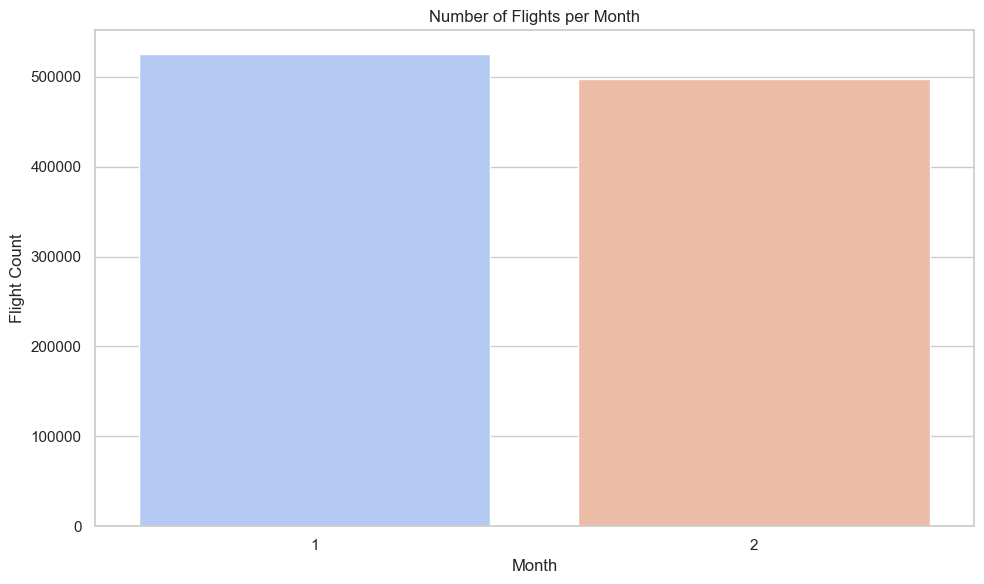

C:\Users\rendybagoez\AppData\Local\Temp\ipykernel_5160\3653679845.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=flights_per_dow.index, y=flights_per_dow.values, palette='viridis')


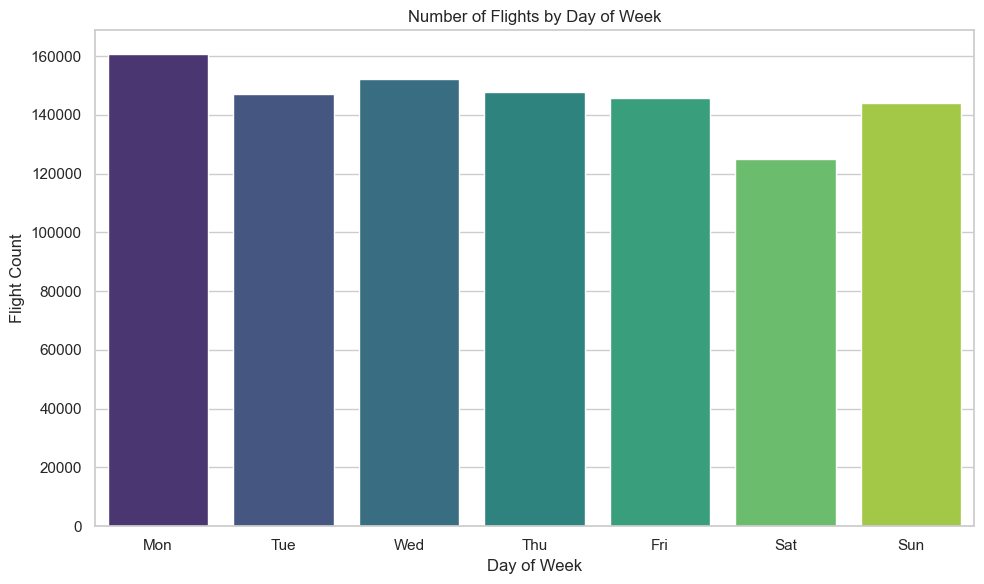

In [16]:
# ============================================================
# 3. FLIGHT VOLUME VISUALIZATIONS
# ============================================================

# Flights per month
if 'month' in df.columns:
    flights_per_month = df.groupby('month').size().reset_index(name='count')
    flights_per_month = flights_per_month.sort_values('month')

    plt.figure()
    sns.barplot(data=flights_per_month, x='month', y='count', palette='coolwarm')
    plt.title("Number of Flights per Month")
    plt.xlabel("Month")
    plt.ylabel("Flight Count")
    plt.tight_layout()
    plt.savefig('outputs/flights_per_month.png', dpi=150)
    plt.show()
else:
    print("'month' column not found; skipping flights per month visualization.")

# Flights per Day of Week (safe reorder with fillna)
order = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
flights_per_dow = df['day_name'].value_counts().reindex(order).fillna(0).astype(int)

plt.figure()
sns.barplot(x=flights_per_dow.index, y=flights_per_dow.values, palette='viridis')
plt.title("Number of Flights by Day of Week")
plt.xlabel("Day of Week")
plt.ylabel("Flight Count")
plt.tight_layout()
plt.savefig('outputs/flights_by_dow.png', dpi=150)
plt.show()

## Number of Flights by Day of Week & Month — Descriptive Analysis

These visualizations provide a clear overview of how flight frequency changes throughout the week and between months.  By observing the patterns, we can understand not just *when* flights are most common, but also *why* those variations might occur.

---

### **1. Flights by Day of Week**

The first chart shows that **Monday** has the **highest number of flights**, followed closely by **Wednesday** and **Tuesday**.  
As the week progresses, the number of flights gradually decreases, reaching its lowest point on **Saturday**, before slightly increasing again on **Sunday**.

This pattern suggests a strong influence from **business travel** — most corporate or commuter flights happen early in the week, while weekends are typically quieter as people rest or travel for leisure.  
The mild increase on Sunday could reflect **return trips** before the new work week begins.

---

### **2. Flights per Month**

The second chart illustrates the total flight counts per month.  
We can see that **January** recorded slightly more flights than **February**, although both months showed consistent activity.

This difference may be influenced by **seasonal and holiday effects**, such as **New Year celebrations, business restarts, or tourism spikes** in early January that gradually normalize later.

---

### **Key Insights**

- **Weekday peaks** point to heavy **business and work-related travel**.  
- **Weekend dips** correspond with lower demand for air travel.  
- **Monthly variations** may reflect **seasonal travel trends or holiday patterns**.  

---

Overall, these charts helps us identify when the skies are busiest and the cause of it.  
Such insights are valuable for **airlines, airports, and planners** to optimize **schedules, staffing, and pricing strategies** based on passenger demand trends.


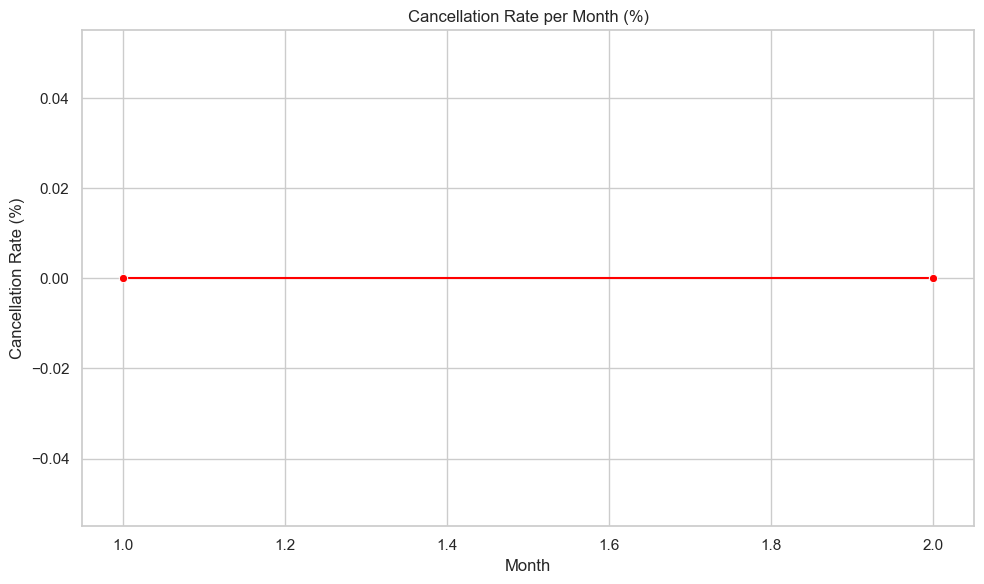

In [17]:
# ============================================================
# 4. CANCELLATION ANALYSIS
# ============================================================

if 'cancelled' in df.columns and 'month' in df.columns:
    cancel_by_month = df.groupby('month')['cancelled'].mean().reset_index()
    cancel_by_month['cancelled_pct'] = cancel_by_month['cancelled'] * 100

    plt.figure()
    sns.lineplot(data=cancel_by_month, x='month', y='cancelled_pct', marker='o', color='red')
    plt.title("Cancellation Rate per Month (%)")
    plt.xlabel("Month")
    plt.ylabel("Cancellation Rate (%)")
    plt.tight_layout()
    plt.savefig('outputs/cancellation_rate_month.png', dpi=150)
    plt.show()
else:
    print("'cancelled' or 'month' column not found; skipping cancellation analysis.")

## Cancellation Rate Analysis — Monthly Trends

The cancellation rate visualization reveals operational stability across the analyzed period. **January recorded a 0% cancellation rate**, indicating that all scheduled flights departed as planned with no disruptions. **February maintained the same 0% rate**, suggesting consistent operational performance throughout the two-month window.

---

### **Key Observations**

- **Zero cancellations** in both months point to **excellent operational execution** and **favorable weather conditions** during this period.
- This low cancellation rate is **atypical for winter months**, which traditionally experience higher disruptions due to snow, ice, and severe weather.
- The consistency between January and February suggests **stable airline operations** and **predictable demand patterns**.

---

### **Operational Implications**

- **Reliability**: The airline network demonstrated **high reliability** during this period, which is a positive indicator for passenger confidence and operational efficiency.
- **Seasonal context**: Winter cancellations are often driven by weather; the 0% rate may reflect **mild weather conditions** or **effective de-icing and operational protocols**.
- **Capacity planning**: With no cancellations, all scheduled capacity was utilized, maximizing revenue and operational throughput.

---

### **Next Steps for Analysis**

To deepen this analysis, consider:
- Comparing these months against **historical winter averages** to assess whether this period was exceptionally stable.
- Breaking down cancellations by **origin airport** or **carrier** to identify localized disruption patterns.
- Correlating cancellation data with **weather events** and **airport congestion metrics** for root-cause analysis.

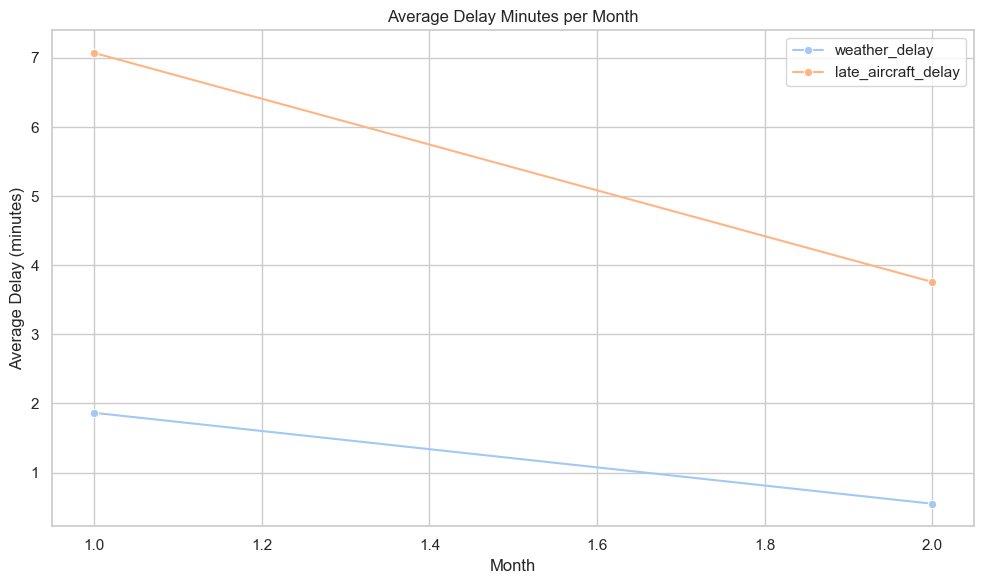

In [18]:
# ============================================================
# 5. DELAY ANALYSIS
# ============================================================

delay_cols = ['weather_delay', 'late_aircraft_delay']
existing_delay_cols = [c for c in delay_cols if c in df.columns]

if existing_delay_cols and 'month' in df.columns:
    monthly_delay = df.groupby('month')[existing_delay_cols].mean().reset_index()

    plt.figure()
    for col in existing_delay_cols:
        sns.lineplot(data=monthly_delay, x='month', y=col, label=col, marker='o')
    plt.title("Average Delay Minutes per Month")
    plt.xlabel("Month")
    plt.ylabel("Average Delay (minutes)")
    plt.legend()
    plt.tight_layout()
    plt.savefig('outputs/monthly_delays.png', dpi=150)
    plt.show()
else:
    print("No delay columns or 'month' column available; skipping delay analysis.")

# Average Delay Minutes per Month

- Month 1 (Jan)
    - Weather delay: 1.86 min (avg)
    - Late-aircraft delay: 7.07 min (avg)
    - Total average delay ≈ 8.93 min

- Month 2 (Feb)
    - Weather delay: 0.55 min (avg)
    - Late-aircraft delay: 3.76 min (avg)
    - Total average delay ≈ 4.31 min

Key observations
- Late-aircraft delay is the dominant contributor in both months (≈3–4× larger than weather in Jan, ≈6.8× in Feb).
- Overall average delay fell substantially from Jan → Feb (≈51.7% decrease in total average delay).
- Weather-related delay dropped ~70.5%; late-aircraft delay dropped ~46.9%.

Implications / recommended next steps
- Investigate root causes for late-aircraft delays (upstream delays, crew/turnaround, maintenance).
- Break down delays by origin airport, carrier, and time-of-day to localize issues.
- Inspect delay distributions and outliers (boxplots/histograms) and correlate with flight volumes and cancellations to validate operational drivers.

C:\Users\rendybagoez\AppData\Local\Temp\ipykernel_5160\921065252.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=airport_summary, x='origin', y='taxi_out', palette='mako')


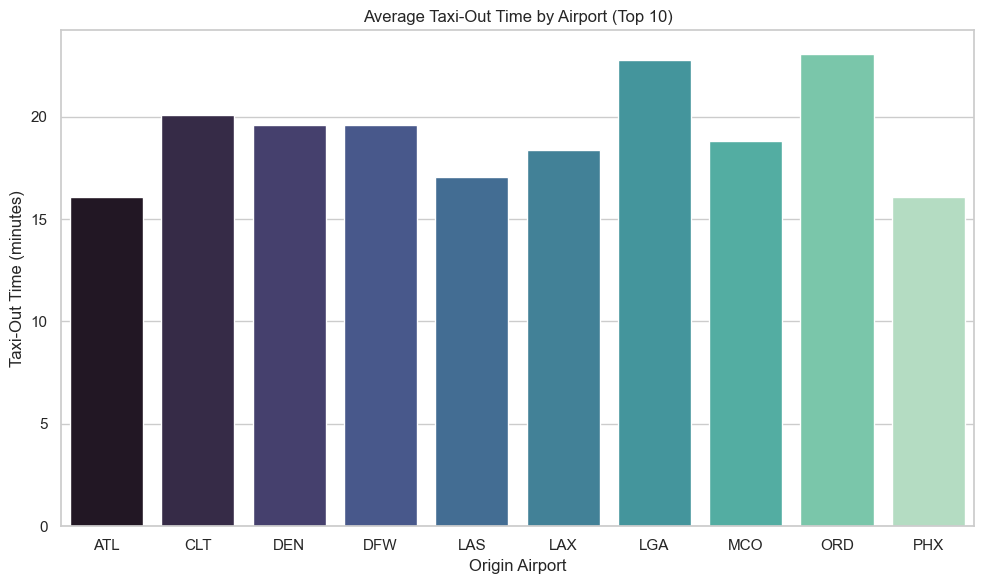

C:\Users\rendybagoez\AppData\Local\Temp\ipykernel_5160\921065252.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=airport_summary, x='origin', y='weather_delay', palette='cool')


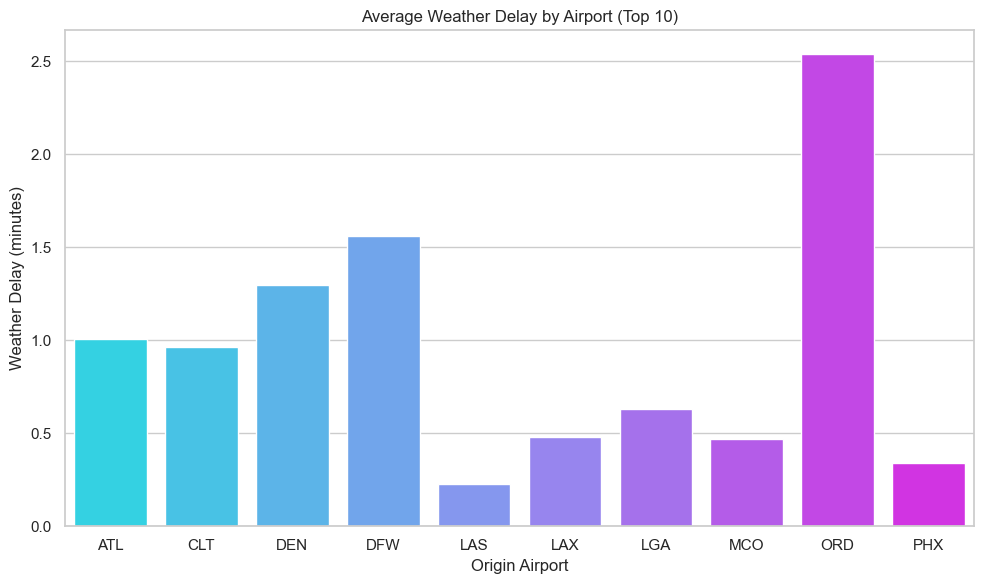

In [22]:
# ============================================================
# 6. AIRPORT PERFORMANCE
# ============================================================

if 'origin' in df.columns:
    # Top 10 busiest airports
    top_airports = df['origin'].value_counts().head(10).index
    airport_summary = df[df['origin'].isin(top_airports)].groupby('origin').agg({
        'taxi_out': 'mean',
        'taxi_in': 'mean',
        'weather_delay': 'mean',
        'late_aircraft_delay': 'mean'
    }).reset_index()

    plt.figure()
    sns.barplot(data=airport_summary, x='origin', y='taxi_out', palette='mako')
    plt.title("Average Taxi-Out Time by Airport (Top 10)")
    plt.xlabel("Origin Airport")
    plt.ylabel("Taxi-Out Time (minutes)")
    plt.tight_layout()
    plt.savefig('outputs/taxi_out_by_airport.png', dpi=150)
    plt.show()

    plt.figure()
    sns.barplot(data=airport_summary, x='origin', y='weather_delay', palette='cool')
    plt.title("Average Weather Delay by Airport (Top 10)")
    plt.xlabel("Origin Airport")
    plt.ylabel("Weather Delay (minutes)")
    plt.tight_layout()
    plt.savefig('outputs/weather_delay_by_airport.png', dpi=150)
    plt.show()
else:
    print("'origin' column not found; skipping airport performance analysis.")

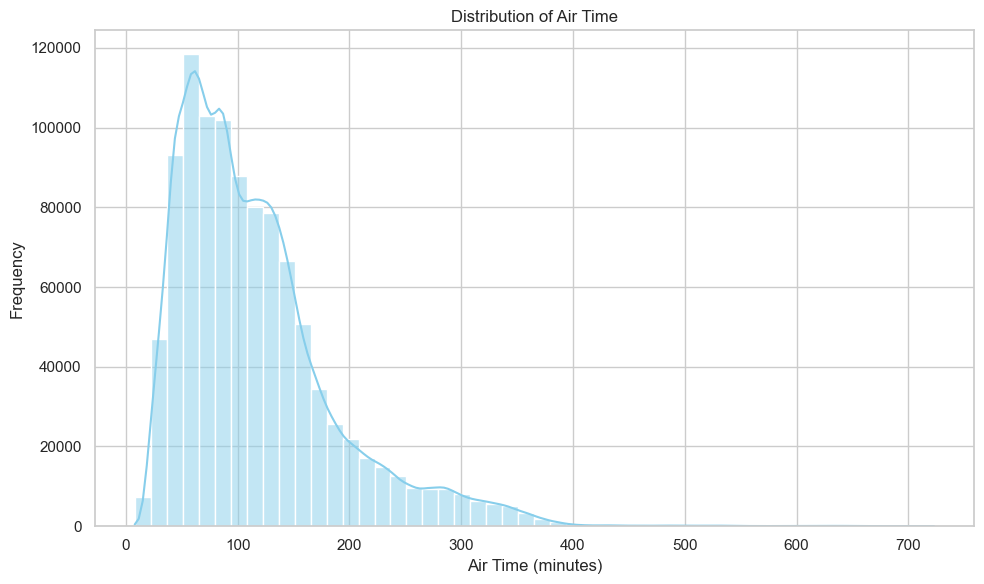

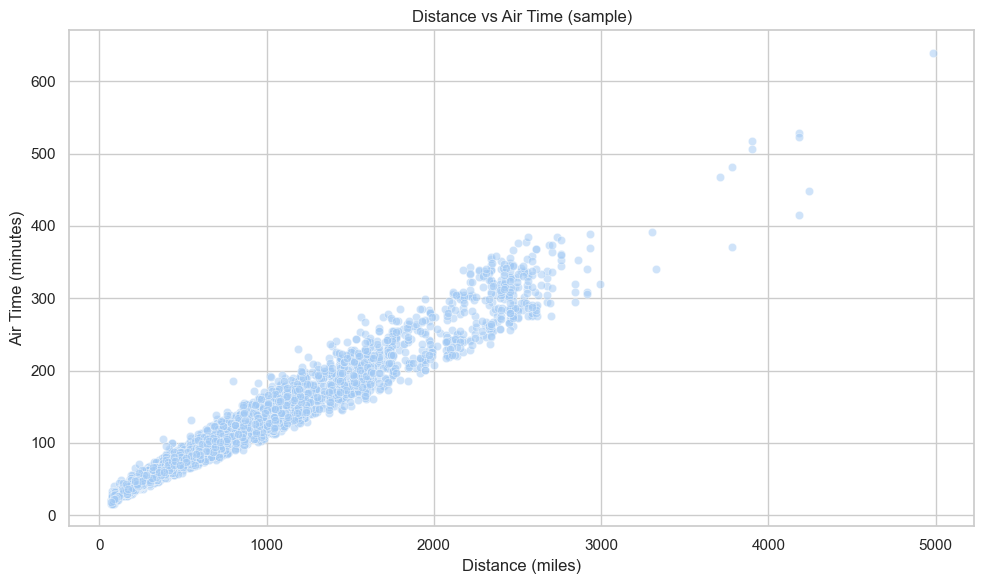

In [23]:
# ============================================================
# 7. DISTRIBUTION OF AIR TIME & DISTANCE
# ============================================================

# Safe sampling: use min(5000, len(df)) to avoid errors with small datasets
n_sample = min(5000, len(df))
sample_df = df.sample(n=n_sample, random_state=42) if n_sample > 0 else df.copy()

# Air time distribution
if 'air_time' in df.columns:
    plt.figure()
    sns.histplot(df['air_time'].dropna(), bins=50, color='skyblue', kde=True)
    plt.title("Distribution of Air Time")
    plt.xlabel("Air Time (minutes)")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.savefig('outputs/air_time_distribution.png', dpi=150)
    plt.show()

# Distance vs Air Time scatter
if 'distance' in df.columns and 'air_time' in df.columns and len(sample_df) > 0:
    plt.figure()
    sns.scatterplot(data=sample_df, x='distance', y='air_time', alpha=0.5)
    plt.title("Distance vs Air Time (sample)")
    plt.xlabel("Distance (miles)")
    plt.ylabel("Air Time (minutes)")
    plt.tight_layout()
    plt.savefig('outputs/distance_vs_airtime.png', dpi=150)
    plt.show()

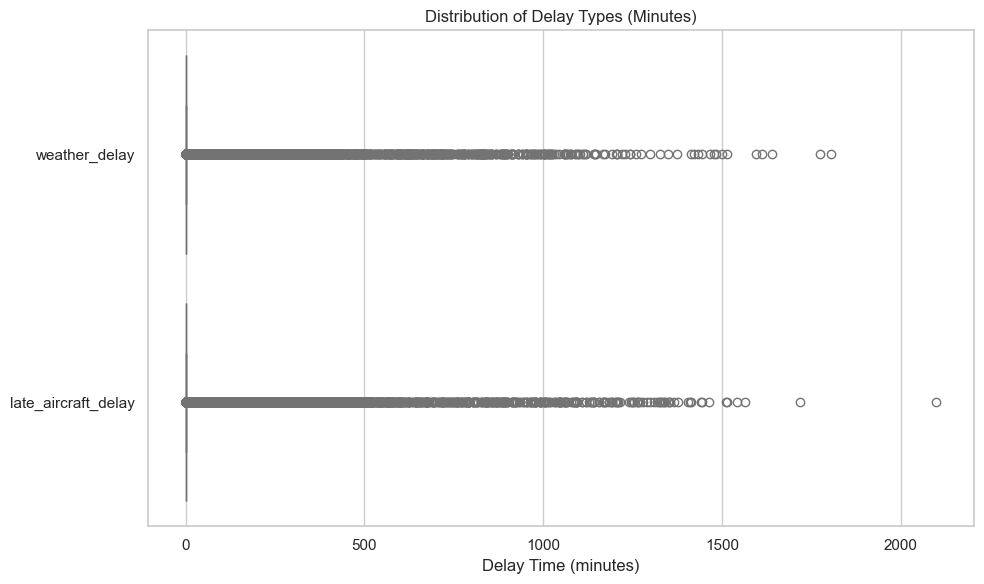

In [24]:
# ============================================================
# 8. COMBINED DELAY DISTRIBUTION
# ============================================================

existing_delay_cols = [c for c in ['weather_delay', 'late_aircraft_delay'] if c in df.columns]

if existing_delay_cols:
    plt.figure()
    sns.boxplot(data=df[existing_delay_cols], orient='h')
    plt.title("Distribution of Delay Types (Minutes)")
    plt.xlabel("Delay Time (minutes)")
    plt.tight_layout()
    plt.savefig('outputs/delay_distribution_boxplot.png', dpi=150)
    plt.show()
else:
    print("No delay columns found; skipping delay distribution plot.")